In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_7_image_16_4_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_12_image_4_2_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_7_image_9_3_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_17_image_20_3_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_20_image_5_1_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_21_image_17_2_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_11_image_2_2_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-dist

In [10]:
!pip install torch torchvision matplotlib

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [12]:
from PIL import Image, UnidentifiedImageError 

class AstronomicalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        
        self.classes = sorted([d for d in os.listdir(root_dir) 
                               if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        skipped = 0
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    skipped += 1
                    continue
                
                img_path = os.path.join(class_path, img_name)
                
               
                try:
                    with Image.open(img_path) as img:
                        img.verify()  
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
                except (IOError, SyntaxError, UnidentifiedImageError):
                    skipped += 1
                  
                    pass
        
        print(f"Successfully loaded {len(self.images)} valid images")
        print(f"Skipped {skipped} invalid or non-image files")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception:
            
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


!ls /kaggle/input/spacenet-an-optimally-distributed-astronomy-data

dataset_root = '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam'


full_dataset = AstronomicalDataset(root_dir=dataset_root, transform=transform)


print(f"Classes found: {full_dataset.classes}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Total valid images: {len(full_dataset)}")

SpaceNet.FLARE.imam_alam
Successfully loaded 11448 valid images
Skipped 1376 invalid or non-image files
Classes found: ['asteroid', 'black hole', 'comet', 'constellation', 'galaxy', 'nebula', 'planet', 'star']
Number of classes: 8
Total valid images: 11448


In [16]:

torch.manual_seed(42)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created successfully!")

Training samples: 9158
Validation samples: 2290
DataLoaders created successfully!


Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


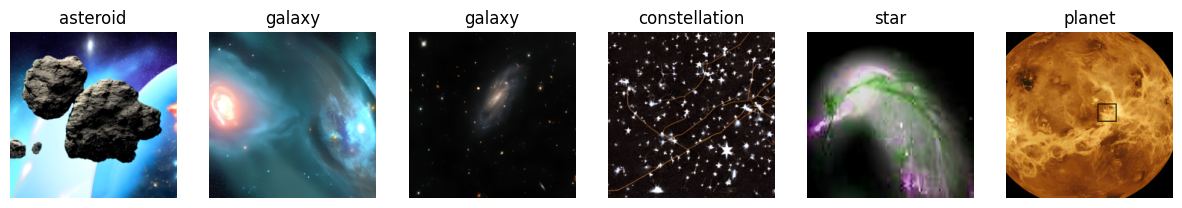

In [17]:

images, labels = next(iter(train_loader))

print(f"Batch image shape: {images.shape}")  
print(f"Batch labels shape: {labels.shape}")


def denormalize(img):
    img = img.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    return img.clamp(0, 1)


fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(full_dataset.classes[labels[i]])
    axes[i].axis('off')
plt.show()

In [18]:
import torch.nn as nn

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


num_classes = len(full_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SimpleCNN(num_classes=num_classes).to(device)
print(model)

Using device: cuda
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_featur

In [20]:
import torch.optim as optim

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model, loss, and optimizer ready!")

Model, loss, and optimizer ready!


In [25]:
num_epochs = 3 #note performing only 3 times as there are time limits and gpu limits

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
   
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/3] | Train Loss: 0.9598 | Val Accuracy: 58.47%
Epoch [2/3] | Train Loss: 0.7217 | Val Accuracy: 57.55%
Epoch [3/3] | Train Loss: 0.5082 | Val Accuracy: 58.52%
